# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland']

%config InlineBackend.figure_format = 'retina'

In [37]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [21]:
final_results = pd.read_csv('data/rt.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [22]:
final_results

ML  Low_90  High_90  Low_50  High_50
country        date                                              
Austria        2020-03-10  3.57    1.59     5.27    2.70     4.21
               2020-03-11  3.55    2.31     4.67    2.96     3.93
               2020-03-12  3.48    2.60     4.34    3.09     3.80
               2020-03-13  3.34    2.64     4.01    3.01     3.57
               2020-03-14  3.03    2.42     3.56    2.78     3.24
...                         ...     ...      ...     ...      ...
United_Kingdom 2020-04-28  0.91    0.81     1.01    0.86     0.94
               2020-04-29  1.00    0.88     1.09    0.94     1.02
               2020-04-30  1.12    1.01     1.21    1.06     1.14
               2020-05-01  1.24    1.13     1.33    1.18     1.26
               2020-05-02  1.31    1.20     1.40    1.25     1.33

[1493 rows x 5 columns]

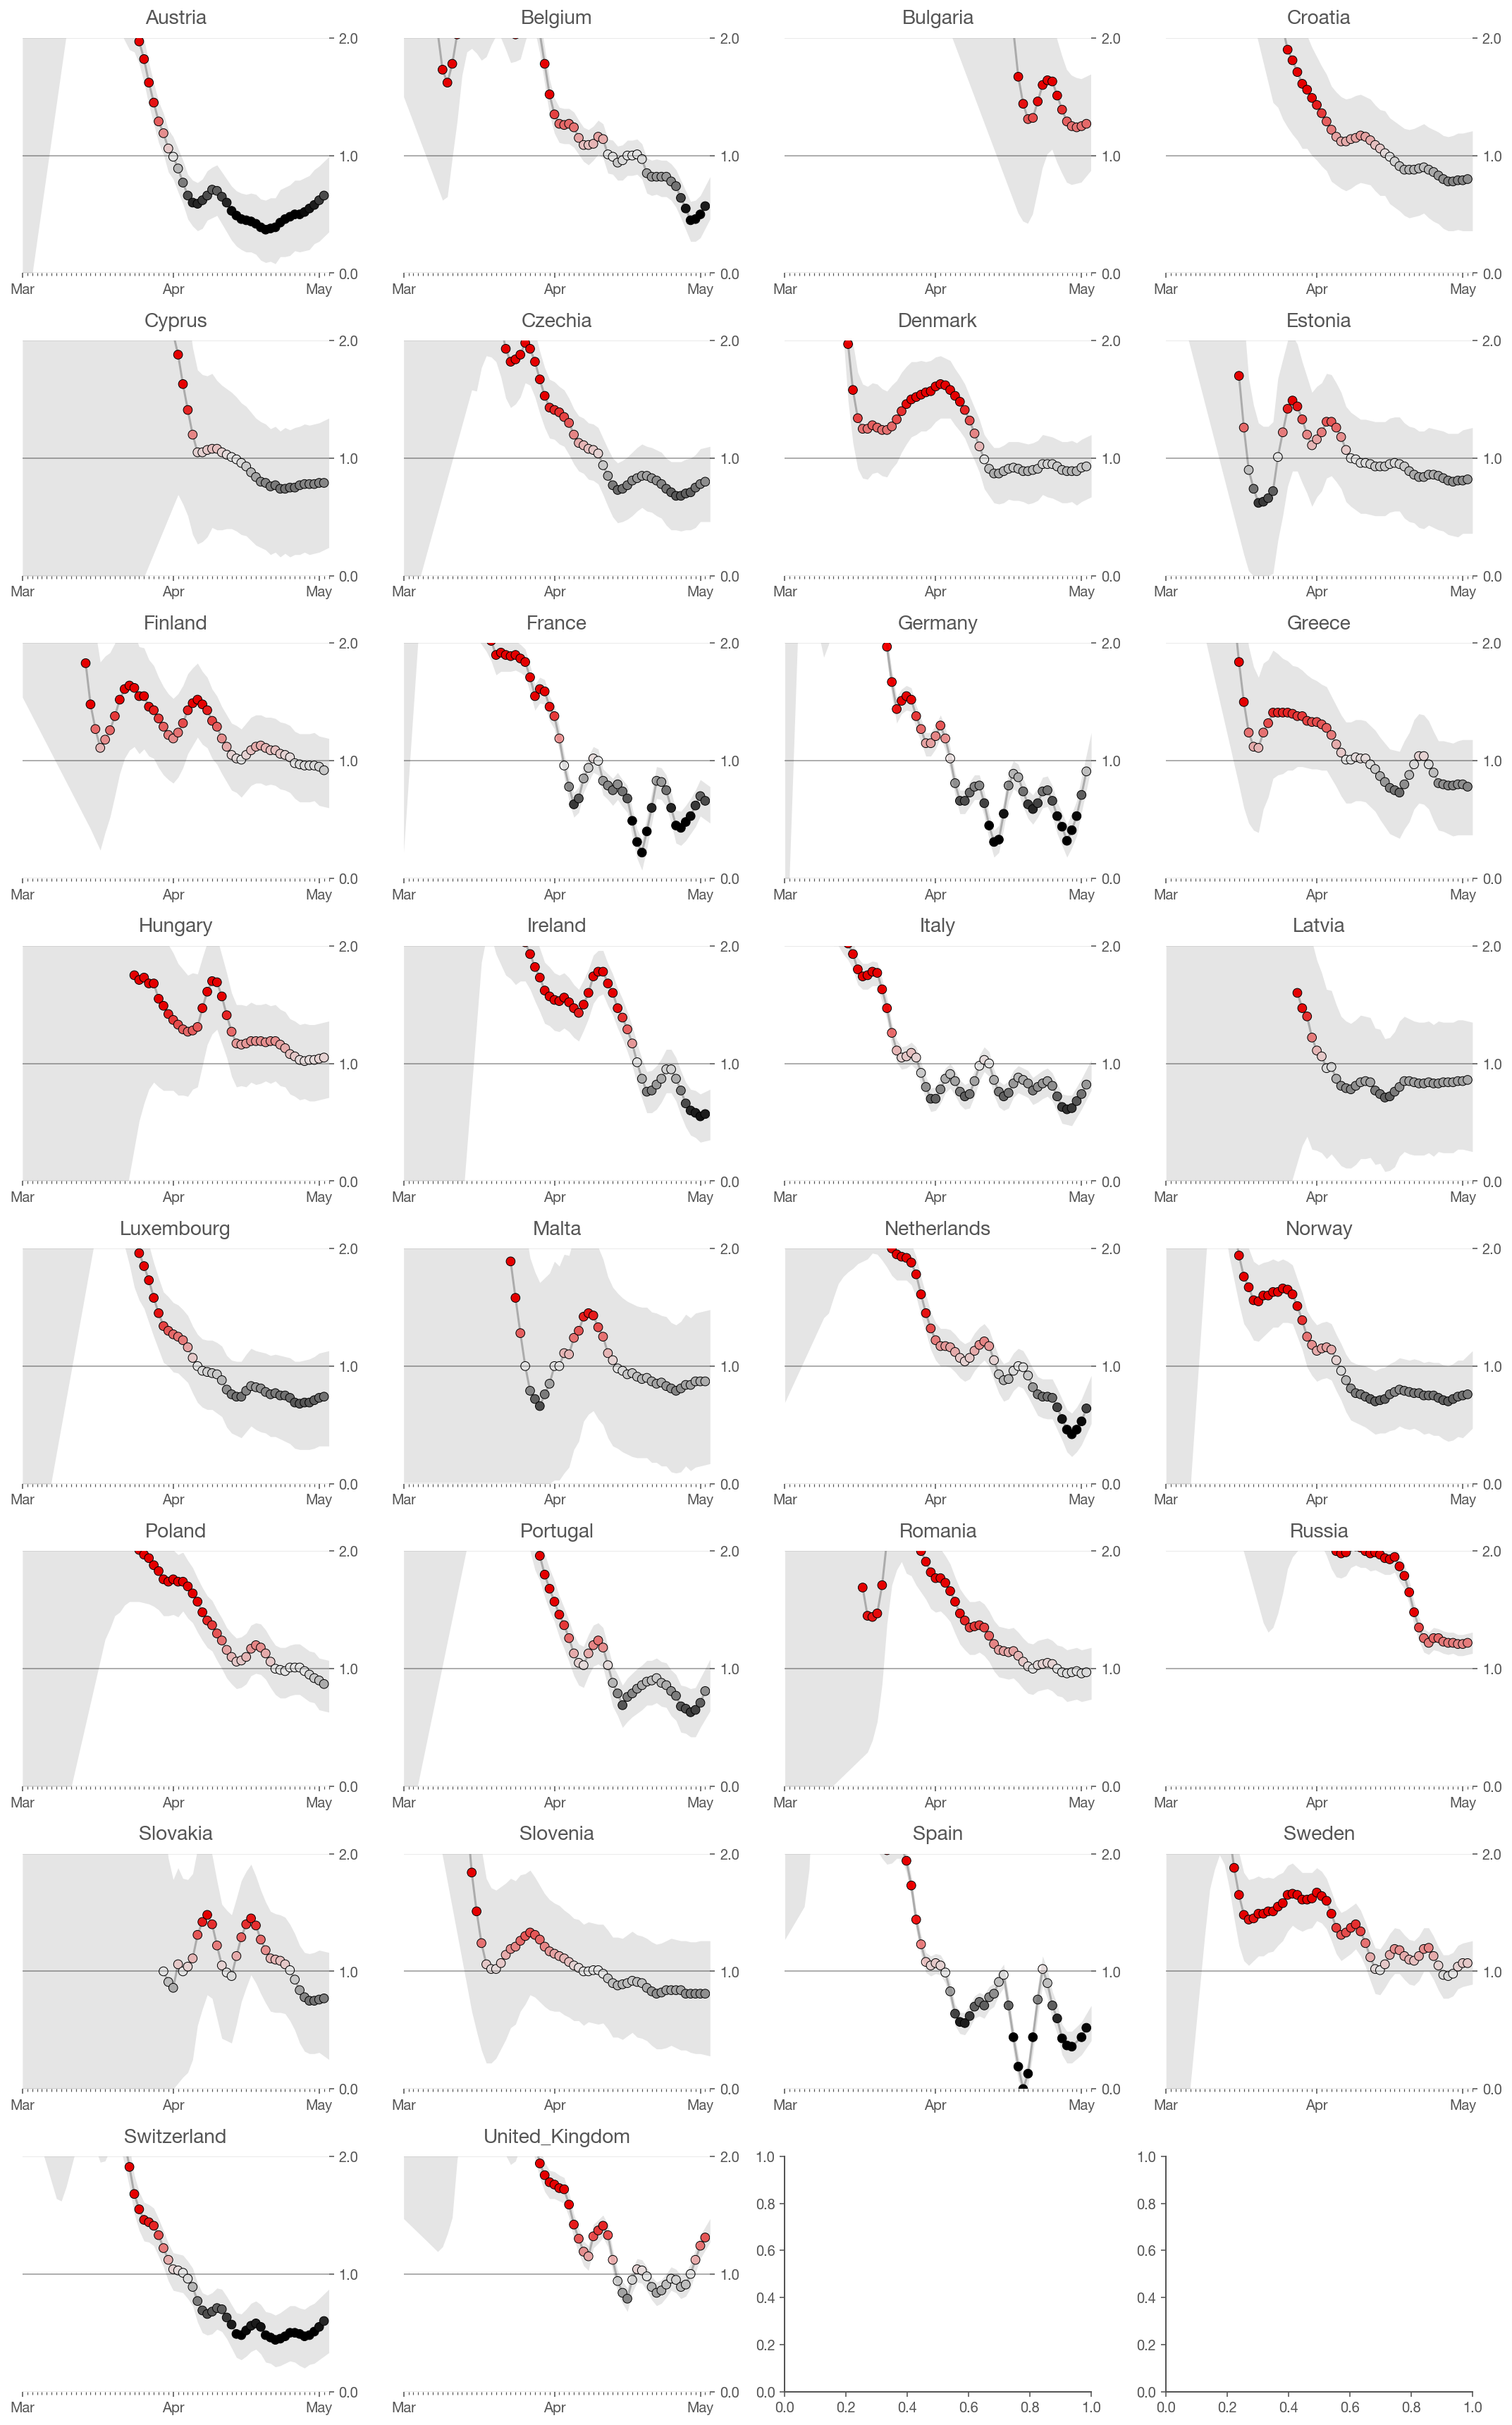

In [38]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [24]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [25]:
no_lockdown = []
partial_lockdown = []

In [26]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv', 
                                    parse_dates=['date'],infer_datetime_format=True,
                                    index_col=['country', 'date'],
                                    squeeze=True)

In [80]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['High_90'] - mr['Low_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

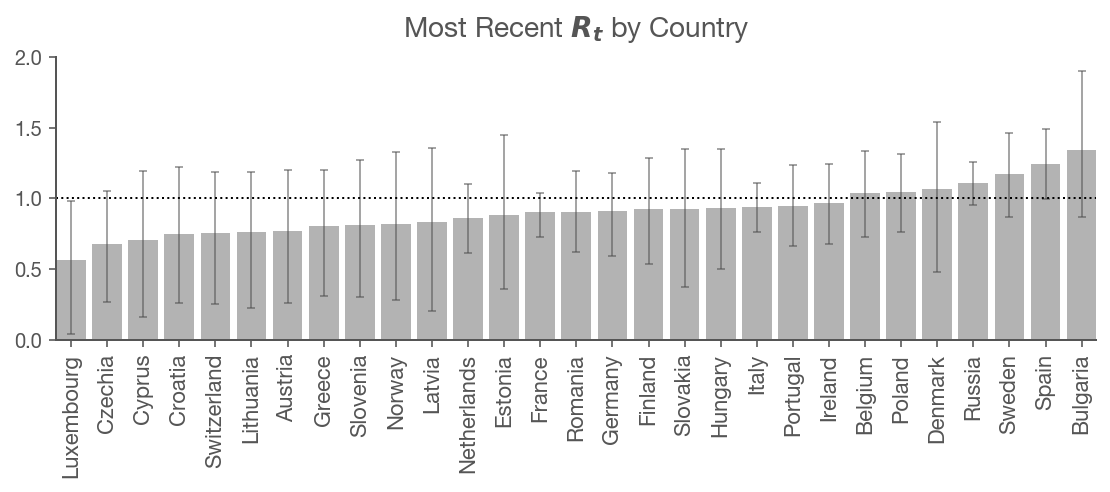

In [28]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_rainier)

## MCMC

In [47]:
final_results_mcmc = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [48]:
final_results_mcmc

mean    median  lower_90  upper_90  lower_50  upper_50
region  date                                                                  
Austria 2020-03-15  1.219638  1.196533  1.005302  1.447499  1.080170  1.238359
        2020-03-16  1.190650  1.166950  1.003216  1.391410  1.049928  1.199794
        2020-03-17  1.155819  1.137235  0.995255  1.334199  1.046443  1.172556
        2020-03-18  1.118518  1.104451  0.964119  1.279537  1.029288  1.153174
        2020-03-19  1.063608  1.053706  0.903378  1.208650  0.992622  1.098550
...                      ...       ...       ...       ...       ...       ...
Germany 2020-04-28  0.907490  0.919326  0.764921  1.060743  0.868575  0.980001
        2020-04-29  0.911784  0.922129  0.744766  1.058435  0.891227  1.003715
        2020-04-30  0.912414  0.920124  0.731508  1.083184  0.877057  0.997616
        2020-05-01  0.910660  0.920739  0.737535  1.116442  0.867384  0.995526
        2020-05-02  0.911605  0.925747  0.703393  1.119682  0.858308  0.990717

[1470 rows x 6 columns]

In [49]:
final_results_mcmc.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']

In [50]:
final_results_mcmc

mean        ML    Low_90   High_90    Low_50   High_50
region  date                                                                  
Austria 2020-03-15  1.219638  1.196533  1.005302  1.447499  1.080170  1.238359
        2020-03-16  1.190650  1.166950  1.003216  1.391410  1.049928  1.199794
        2020-03-17  1.155819  1.137235  0.995255  1.334199  1.046443  1.172556
        2020-03-18  1.118518  1.104451  0.964119  1.279537  1.029288  1.153174
        2020-03-19  1.063608  1.053706  0.903378  1.208650  0.992622  1.098550
...                      ...       ...       ...       ...       ...       ...
Germany 2020-04-28  0.907490  0.919326  0.764921  1.060743  0.868575  0.980001
        2020-04-29  0.911784  0.922129  0.744766  1.058435  0.891227  1.003715
        2020-04-30  0.912414  0.920124  0.731508  1.083184  0.877057  0.997616
        2020-05-01  0.910660  0.920739  0.737535  1.116442  0.867384  0.995526
        2020-05-02  0.911605  0.925747  0.703393  1.119682  0.858308  0.990717

[1470 rows x 6 columns]

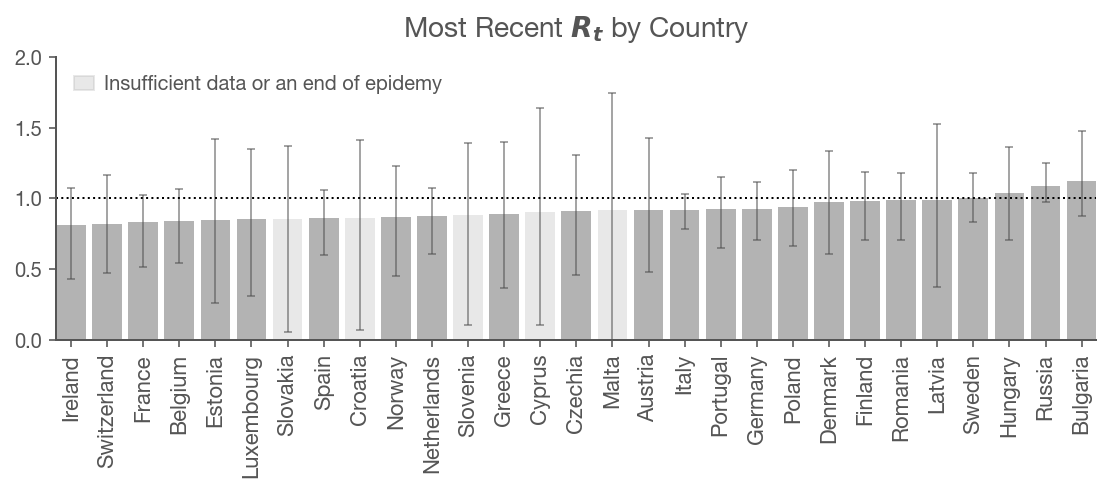

In [81]:
targets_mcmc = final_results_mcmc.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr_mcmc = final_results_mcmc.loc[targets_mcmc].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_mcmc.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_mcmc)

In [82]:
# export to be used on the website
fig.savefig('plots/standings.png', bbox_inches='tight', dpi=200)

In [ ]:
ncountries = len(final_results_mcmc.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_mcmc.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')